In [58]:
# Importing necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# Creating a Function to resize images in a given folder

def resize_images(folder_path, target_size=(224, 224)):
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".jpeg"):
            filepath = os.path.join(folder_path, filename)
            img = cv2.imread(filepath)
            resized_img = cv2.resize(img, target_size)
            cv2.imwrite(filepath, resized_img)

# Resize images in the training set
resize_images('/content/drive/MyDrive/Assignment/Assignment/Training/resume')
resize_images('/content/drive/MyDrive/Assignment/Assignment/Training/non_resume')

# Resize images in the testing set
resize_images('/content/drive/MyDrive/Assignment/Assignment/Testing/resume')
resize_images('/content/drive/MyDrive/Assignment/Assignment/Testing/non_resume')

In [61]:
# Define paths
train_data_dir = '/content/drive/MyDrive/Assignment/Assignment/Training'
test_data_dir = '/content/drive/MyDrive/Assignment/Assignment/Testing'

In [62]:
# Data Augmentation for Testing (with minimal augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for testing

In [63]:
# Data Preparation for Training
batch_size = 25

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest',
    validation_split=0.2,  # 20% for validation
    channel_shift_range=20,
    featurewise_center=True,
    featurewise_std_normalization=True,
    zca_whitening=True,
)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1451: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn(


In [64]:
# Data Preparation for Training
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',  # 80% for training
)

Found 80 images belonging to 2 classes.


In [65]:
# Data Preparation for Validation
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',  # 20% for validation
)

Found 20 images belonging to 2 classes.


In [66]:
# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [67]:
# Loading the pre-trained ResNet50 model
base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),
                                            include_top=False,
                                            weights='imagenet')

# Freezing the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Building my own custom model on top of the pre-trained ResNet50
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

The model selection in this code is based on utilizing the ResNet50 architecture for the resume classification task. The rationale behind this choice is:

The choice of ResNet50, combined with additional layers and appropriate training strategies, reflects a robust approach for image classification tasks, ensuring effective learning and performance on the specific task of resume classification.

In [68]:
# Model Training with Validation Data and Class Weights
epochs = 20
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1885: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/20
4/4 [==============================] - 16s 3s/step - loss: 0.9836 - accuracy: 0.4250 - val_loss: 0.6824 - val_accuracy: 0.5000
Epoch 2/20
4/4 [==============================] - 2s 433ms/step - loss: 0.7530 - accuracy: 0.5250 - val_loss: 0.6964 - val_accuracy: 0.5000
Epoch 3/20
4/4 [==============================] - 2s 480ms/step - loss: 0.6992 - accuracy: 0.5625 - val_loss: 0.6722 - val_accuracy: 0.5000
Epoch 4/20
4/4 [==============================] - 2s 460ms/step - loss: 0.6995 - accuracy: 0.6125 - val_loss: 0.6696 - val_accuracy: 0.5000
Epoch 5/20
4/4 [==============================] - 3s 719ms/step - loss: 0.7828 - accuracy: 0.5250 - val_loss: 0.5954 - val_accuracy: 0.9000
Epoch 6/20
4/4 [==============================] - 3s 697ms/step - loss: 0.6209 - accuracy: 0.6625 - val_loss: 0.5742 - val_accuracy: 0.6500
Epoch 7/20
4/4 [==============================] - 2s 434ms/step - loss: 0.6589 - accuracy: 0.6000 - val_loss: 0.6349 - val_accuracy: 0.7000
Epoch 8/20
4/4 [======

In [69]:
# Testing and Evaluation
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 60 images belonging to 2 classes.


In [70]:
# Predictions and Classifications
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int)

3/3 [==============================] - 1s 105ms/step


In [71]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [72]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
classification_rep = classification_report(true_classes, predicted_classes)

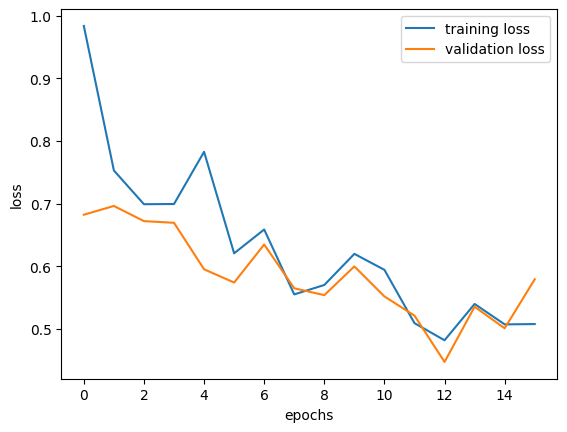

In [73]:
# plot of loss curves
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

The evaluation metrics for project are:
Confusion Matrix and Classification Report

In [74]:
# confusion matrix and classification report
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

Confusion Matrix:
[[26  4]
 [ 1 29]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91        30
           1       0.88      0.97      0.92        30

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



Model's Strengths:High Accuracy and
Balanced Precision and Recall

Model's Limitations: Small Dataset Consideration

Significance of True Positives, False Positives, and False Negatives:

True Positives (TP):
Significance: True positives represent the successful identification of resumes.
29 resumes correctly identified.

False Positives (FP):
Significance: False positives indicate the model's tendency to misclassify non-resumes as resumes
4 non-resumes incorrectly classified as resumes.

False Negatives (FN):
Significance: False negatives highlight the model's failure to recognize actual resumes
1 resume missed by the model


In [75]:
#saving the model
model.save('/content/drive/MyDrive/Assignment/Assignment/resume_classifier_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [76]:
# Loading the trained model
saved_model_path = '/content/drive/MyDrive/Assignment/Assignment/resume_classifier_model.h5'
loaded_model = load_model(saved_model_path)

In [77]:
# Loading and preprocessing the new image
new_image_path = '/content/resume_test.jpg'
img = image.load_img(new_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image

In [78]:
# predictions
prediction = loaded_model.predict(img_array)

# Interpret the prediction
if prediction[0][0] > 0.5:
    print("The image is classified as a resume.")
else:
    print("The image is not classified as a resume.")

1/1 [==============================] - 1s 1s/step
The image is classified as a resume.
